## PSD of BaroData

In [1]:
import matplotlib.pyplot as plt
import os

from obspy import UTCDateTime, read, Stream, Trace, read_inventory
from obspy import read_inventory

from andbro__read_sds import __read_sds
from andbro__load_FURT_stream import __load_furt_stream

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay200_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay200_path = '/bay200/'

In [5]:
# tbeg, tend = UTCDateTime("2023-09-03"), UTCDateTime("2023-09-07")
# tbeg, tend = UTCDateTime("2023-11-05"), UTCDateTime("2023-11-22")
tbeg, tend = UTCDateTime("2023-10-01"), UTCDateTime("2023-10-07")

# path_to_figs = root_path+"Documents/ROMY/ROMY_infrasound/figures/"
path_to_figs = data_path+"LNM2/figures/baro/"

## time of inlet below gravel
t_gravel = UTCDateTime("2023-09-20 12:00")

##
t_gravel_filter = UTCDateTime("2023-10-05 12:00")

##
t_mushroom_filter = UTCDateTime("2023-10-13 16:00")

##
t_mushroom_foam_filter = UTCDateTime("2023-11-09 13:00")

##
t_mushroom_foam_porous = UTCDateTime("2023-11-17 12:00")

# FFBI DATA

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


2 Trace(s) in Stream:
BW.FFBI..BDF | 2023-10-01T00:00:00.004999Z - 2023-10-02T00:00:00.004999Z | 40.0 Hz, 3456001 samples
BW.FFBI..BDO | 2023-10-01T00:00:00.005000Z - 2023-10-02T00:00:00.005000Z | 40.0 Hz, 3456001 samples


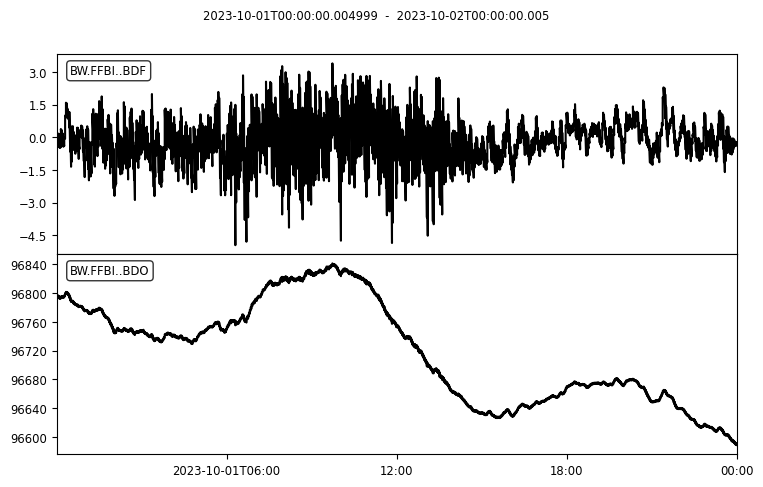

In [6]:

## period to check data... one sided differential signals...
# tbeg, tend = "2023-08-13","2023-08-20"
# ffbi = __read_sds("/import/kilauea-data/LNM2/mb2000/sds/", "BW.IROMY..BD*", tbeg, tend)

ffbi = __read_sds(bay200_path+"mseed_online/archive/", "BW.FFBI..BD*", tbeg, tend)


if len(ffbi) != 2:
    ffbi.merge();

ffbi_inv = read_inventory(root_path+"/Documents/ROMY/ROMY_infrasound/station_BW_FFBI.xml")
# ffbi = ffbi.remove_response(ffbi_inv, water_level=10)

ffbi_no_response = ffbi.copy()
for tr in ffbi_no_response:
    tr.data = tr.data *1.589e-6 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 V/Pa

## remove gain and sensitivity
for tr in ffbi:
    if "F" in tr.stats.channel:
        # tr = tr.remove_response(ffbi_inv)
        # tr.data = tr.data *1.589e-6 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 V/Pa
        # tr.data = tr.data *1/629129.0 /0.02  # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity_mb2005=0.02 V/Pa
        tr = tr.remove_response(ffbi_inv, water_level=10, plot=False)
    elif "O" in tr.stats.channel:
        tr.data = tr.data *1.589e-6 *1e5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 0.001 V/hPa
        # tr.data = tr.data *1/629129.0 *1e5   # gain=1 sensitivity_reftek=6.28099e5count/V; sensitivity = 0.001 V/hPa

ffbi.merge();

print(ffbi)

ffbi.plot(equal_scale=False);

In [7]:
def __welch_psd(arr, dt, twin_sec=60):

    from scipy.signal import welch
    from scipy.signal.windows import hann

    nblock = int(1/dt * twin_sec)
    overlap = int(0.5*nblock)
    win = hann(nblock, True)

    ff, Pxx = welch(arr,
                    fs=1/dt,
                    window=win, noverlap=overlap,
                    nfft=nblock,
                    scaling="density",
                    return_onesided=True)

    return ff, Pxx

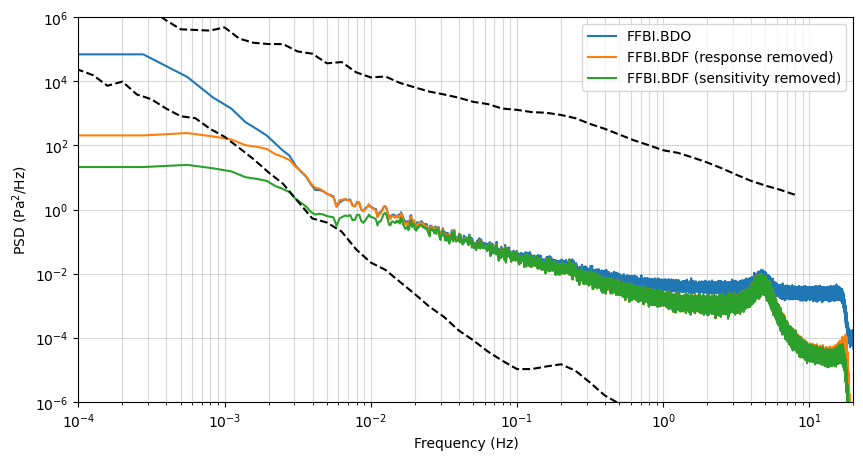

In [8]:
f1, psd1 = __welch_psd(ffbi.select(channel="BDF")[0].data, ffbi[0].stats.delta, twin_sec=3600)
f2, psd2 = __welch_psd(ffbi.select(channel="BDO")[0].data, ffbi[0].stats.delta, twin_sec=3600)
f3, psd3 = __welch_psd(ffbi_no_response.select(channel="BDF")[0].data, ffbi[0].stats.delta, twin_sec=3600)

from pandas import read_csv

baro_lnm = read_csv(data_path+f"LNM2/data/"+"baro_nlnm_nhnm.csv")

baro_lnm['nlnm_baro'] = 10**(baro_lnm['nlnm_baro_db']/10)
baro_lnm['nhnm_baro'] = 10**(baro_lnm['nhnm_baro_db']/10)


fig = plt.figure(figsize=(10, 5))

plt.loglog(f2, psd2, label="FFBI.BDO")
plt.loglog(f1, psd1, label="FFBI.BDF (response removed)")
plt.loglog(f3, psd3, label="FFBI.BDF (sensitivity removed)")

plt.loglog(baro_lnm['frequency'], baro_lnm['nlnm_baro'], c="k", ls="--")
plt.loglog(baro_lnm['frequency'], baro_lnm['nhnm_baro'], c="k", ls="--")
plt.xlim(1e-4, 2e1)
plt.ylim(1e-6, 1e6)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (Pa$^2$/Hz)")

plt.legend()
plt.grid(which="both", alpha=0.5, zorder=0)
plt.show();

fig.savefig(path_to_figs+"CheckUp_BDO_BDF_response.png", format="png", dpi=150, bbox_inches='tight');

## PROMY Data

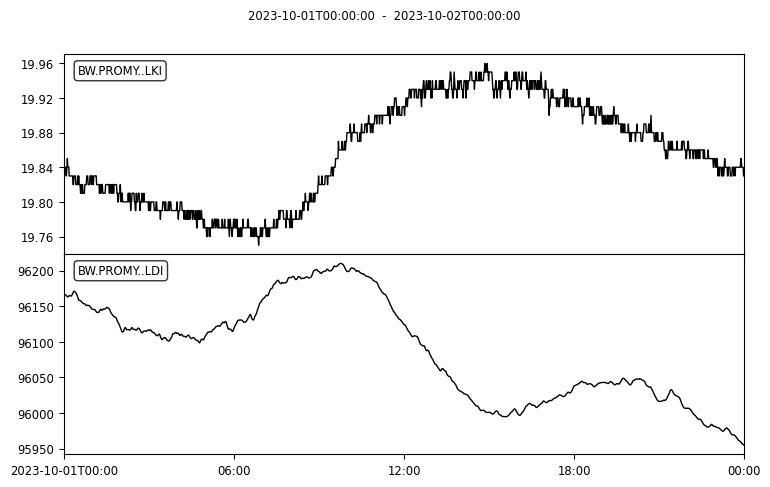

In [9]:
promy = __read_sds(archive_path+"romy_archive/", "BW.PROMY..L*", tbeg, tend)
promy.merge();
promy.plot(equal_scale=False);

# FURT Data

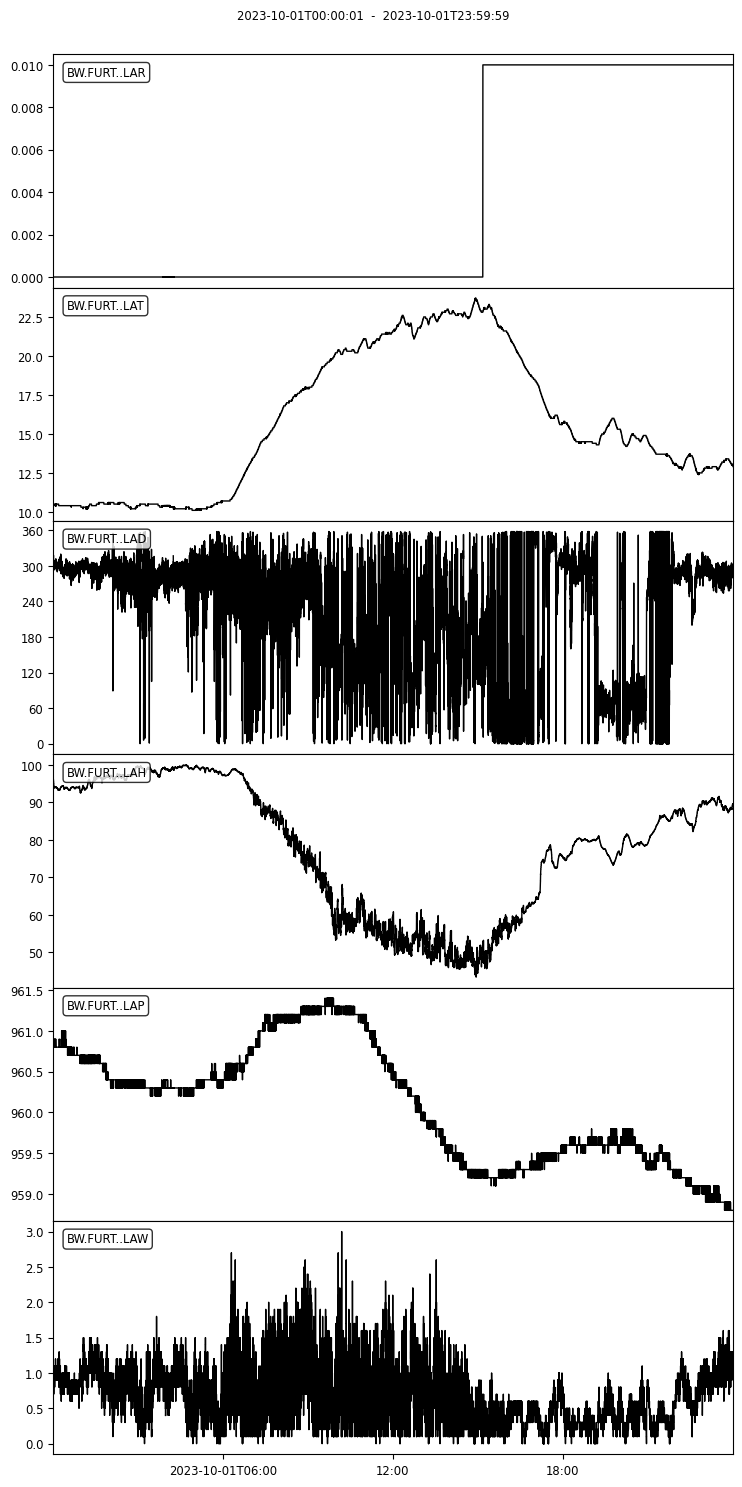

In [10]:
furt = __load_furt_stream(tbeg, tend, show_raw=False, sampling_rate=1.0, path_to_archive=bay200_path+"gif_online/FURT/WETTER/")

furt.plot(equal_scale=False);

## Plot Data

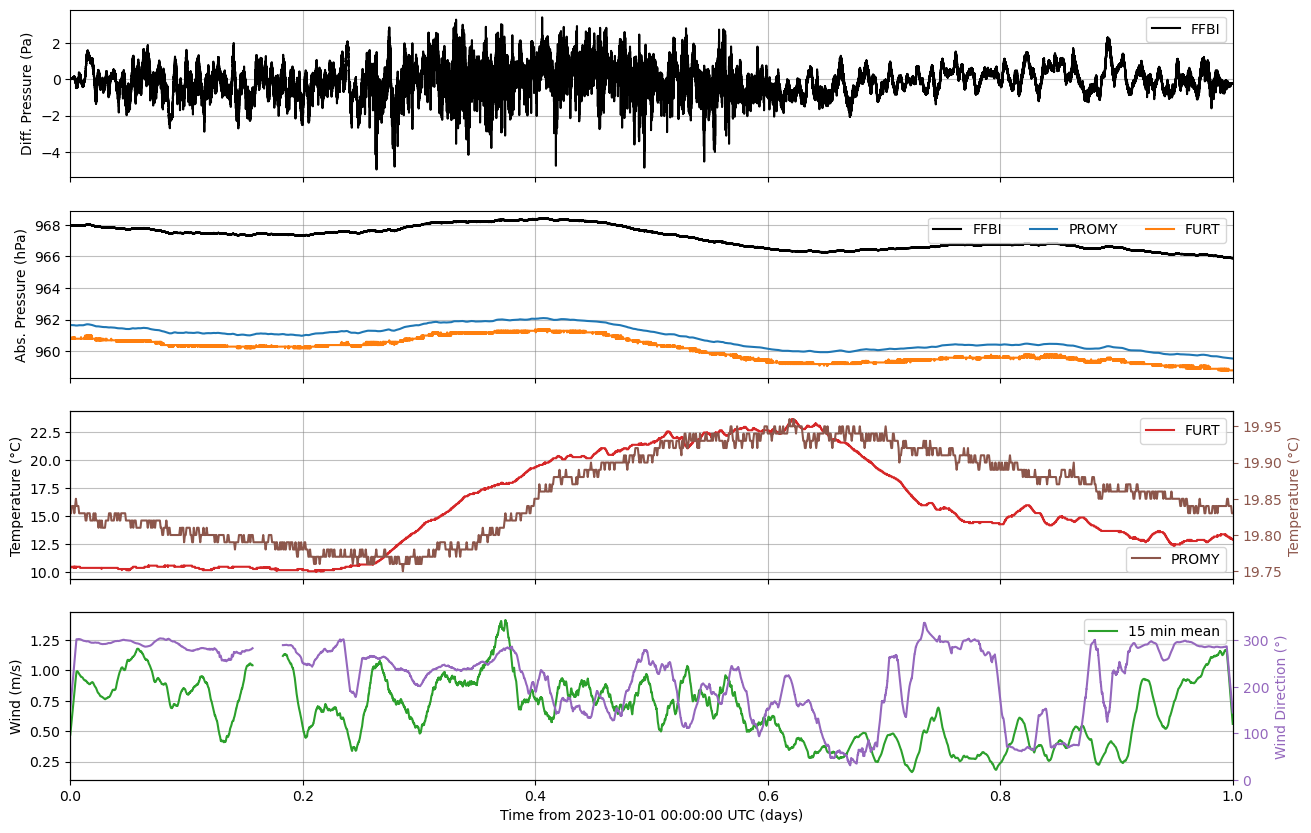

In [11]:
def __makeplot_overview():

    fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

    def smooth(y, box_pts):
        from numpy import ones, convolve, zeros, array, concatenate
        box = ones(box_pts)/box_pts
        y = concatenate((zeros(box_pts), array(y), zeros(box_pts)))
        y_smooth = convolve(y, box, mode='same')
        return y_smooth[box_pts:-box_pts]


    time_scaling = 86400

    ax[0].plot(ffbi.select(channel="*F")[0].times()/time_scaling, ffbi.select(channel="*F")[0].data, label="FFBI", color="k")


    ax[1].plot(ffbi.select(channel="*O")[0].times()/time_scaling, ffbi.select(channel="*O")[0].data/100, label="FFBI", color="k")
    ax[1].plot(promy.select(channel="LDI")[0].times()/time_scaling, promy.select(channel="LDI")[0].data/100, label="PROMY", color="tab:blue")
    ax[1].plot(furt.select(channel="LAP")[0].times()/time_scaling, furt.select(channel="LAP")[0].data, label="FURT", color="tab:orange")


    ax[2].plot(furt.select(channel="LAT")[0].times()/time_scaling, furt.select(channel="LAT")[0].data, label="FURT", color="tab:red")
    ax22 = ax[2].twinx()
    ax22.plot(promy.select(channel="LKI")[0].times()/time_scaling, promy.select(channel="LKI")[0].data, label="PROMY", color="tab:brown")
    ax22.legend(loc=4)
    ax22.tick_params(axis='y', colors="tab:brown")

    wind_force = smooth(furt.select(channel="LAW")[0].data, 900)
    ax[3].plot(furt.select(channel="LAW")[0].times()/time_scaling, wind_force, color="tab:green", label="15 min mean")

    ax32 = ax[3].twinx()
    wind_direction = smooth(furt.select(channel="LAD")[0].data, 900)
    ax32.plot(furt.select(channel="LAD")[0].times()/time_scaling, wind_direction, color="tab:purple", label="15 min mean")
    ax32.set_ylim(0, 360)
    ax32.tick_params(axis='y', colors="tab:purple")


    ax22.set_ylabel("Temperature (°C)", color="tab:brown")
    ax32.set_ylabel("Wind Direction (°)", color="tab:purple")
    ax[0].set_ylabel("Diff. Pressure (Pa)")
    ax[1].set_ylabel("Abs. Pressure (hPa)")
    ax[2].set_ylabel("Temperature (°C)")
    ax[3].set_ylabel("Wind (m/s)")

    ax[3].set_xlabel(f"Time from {tbeg.date} {str(tbeg.time).split('.')[0]} UTC (days)")

    for i in range(4):
        ax[i].grid(alpha=0.5, color="grey", zorder=0)
        ax[i].legend()
        ax[i].axvline((t_gravel-tbeg)/time_scaling, color="darkblue", ls="--")
        ax[i].axvline((t_mushroom_filter-tbeg)/time_scaling, color="purple", ls="--")
        ax[i].axvline((t_gravel_filter-tbeg)/time_scaling, color="cyan", ls="--")
        ax[i].axvline((t_mushroom_foam_filter-tbeg)/time_scaling, color="darkred", ls="--")
        ax[i].axvline((t_mushroom_foam_porous-tbeg)/time_scaling, color="darkgreen", ls="--")


    ax[1].legend(ncol=3)

    # ax[1].set_ylim(900, 970)
    ax[3].set_xlim(0, max(ffbi.select(channel="*F")[0].times()/time_scaling))

    plt.show();
    return fig

fig = __makeplot_overview()

fig.savefig(path_to_figs+f"comparison_{tbeg.date}_{tend.date}.png", dpi=200, format="png", bbox_inches='tight')


### Continueous Wavelet Transform

In [12]:
from functions.compute_cwt import __compute_cwt

In [13]:
def __compute_cwt(times, arr1, tdelta, datalabel="dat1", cmap_scale="lin", period=False, tscale='sec', fmax=None, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance, cwt
    from numpy import std, nanmean, nan, nanmax, nanmin, nanvar, ones, nan_to_num, polyfit, polyval, array, reshape, nanpercentile
    from numpy import sum as npsum

    import matplotlib.colors as colors
    import matplotlib.pyplot as plt

    times = array(times, dtype='float64')
    arr1 = array(arr1, dtype='float64')

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask


    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## detrend data
    p = polyfit(times - times[0], arr1, 1)
    dat_notrend = arr1 - polyval(p, times - times[0])
    std = dat_notrend.std()  # Standard deviation
    var = std ** 2  # Variance
    arr1 = dat_notrend / std  # Normalized dataset

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)


    cwt, scales, ff_cwt, cone_p, fft, fftfreqs = cwt(
                                                        arr1,
                                                        dt=dt,
                                                        dj=dj_set, #0.05,
                                                        s0=s0_set, #-1,
                                                        J=J_set, #-1,
                                                        wavelet=mother_wavelet,  # u'morlet',
                                                    )

    cone_f = 1/cone_p
    pp_cwt = 1/ff_cwt

    if tscale == "min":
        times /= 60
        cone_p /= 60
        pp_cwt /= 60
        unit = "min"
    elif tscale == "hour":
        times /= 3600
        cone_p /= 3600
        pp_cwt /= 3600
        unit = "hour"
    else:
        unit = "s"

    ## building cone
    mask_cone = __mask_cone(cwt, ff_cwt, cone_f, fill=nan)


    ## get real part
    cwt_power = abs(cwt)

    ## normalize cross wavelet transform
    if normalize:
        cwt_power /= nanmax(cwt_power.reshape((1, cwt_power.size))[0])

    ## apply masks
    # cwt_power_masked = cwt_power * mask_cwt * mask_cone
    cwt_power_masked = cwt_power * mask_cone

    ## compute global cross wavelet transform power
    global_mean_cwt_f = nanmean(cwt_power_masked, axis=1)
    global_sum_cwt_f = npsum(nan_to_num(cwt_power_masked, 0), axis=1)

    if normalize:
        global_sum_cwt_f /= max(global_sum_cwt_f)
        global_mean_cwt_f /= max(global_mean_cwt_f)


    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 4, 3

        font = 12

        fig = plt.figure(figsize=(15, 8))

        gs = GridSpec(Nrow, Ncol, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1:, :-1])
        ax3 = fig.add_subplot(gs[1:, 3:])

        ax1.set_xticklabels([])
        ax3.set_yticklabels([])

        plt.subplots_adjust(hspace=0.1, wspace=0.1)


        ax1.plot(times, arr1, alpha=1, color="black", lw=1, label=datalabel)

        ax1.set_xlim(min(times), max(times))
        ax1.set_ylabel("Amplitude", fontsize=font)
        ax1.legend(loc=1)

        max_power = nanpercentile(reshape(cwt_power, cwt_power.size), 95)
        min_power = nanpercentile(reshape(cwt_power, cwt_power.size), 5)

        if period:
            if cmap_scale == "log":
                ca2 = ax2.pcolormesh(
                                    times,
                                    pp_cwt,
                                    cwt_power,
                                    norm=colors.LogNorm(min_power, max_power),
                                    rasterized=True,
                                    )

                ax3.plot(global_mean_cwt_f, pp_cwt, color="black", label="global mean power")
                # ax3.plot(global_sum_cwt_f, pp_cwt, color="darkred", label="global sum power")
            else:
                ca2 = ax2.pcolormesh(
                                    times,
                                    pp_cwt,
                                    cwt_power,
                                    vmin=min(reshape(cwt_power, cwt_power.size)),
                                    vmax=max(reshape(cwt_power, cwt_power.size)),
                                    rasterized=True,
                                    )

                ax3.plot(global_mean_cwt_f, pp_cwt, color="black", label="global mean power")
                # ax3.plot(global_sum_cwt_f, pp_cwt, color="darkred", label="global sum power")

        else:
            if cmap_scale == "log":

                ca2 = ax2.pcolormesh(
                                    times,
                                    ff_cwt,
                                    cwt_power,
                                    norm=colors.LogNorm(min_power, max_power),
                                    rasterized=True,
                                    )
                ax3.plot(global_mean_cwt_f, ff_cwt, color="black", label="global mean power")
                # ax3.plot(global_sum_cwt_f, ff_cwt, color="darkred", label="global sum power")

            else:
                ca2 = ax2.pcolormesh(
                                    times,
                                    ff_cwt,
                                    cwt_power,
                                    vmin=min(reshape(cwt_power, cwt_power.size)),
                                    vmax=max(reshape(cwt_power, cwt_power.size)),
                                    rasterized=True,
                                    )

            ax3.plot(global_mean_cwt_f, ff_cwt, color="black", label="global mean power")
            # ax3.plot(global_sum_cwt_f, ff_cwt, color="darkred", label="global sum power")

        if period:
            ax2.plot(times, cone_p, color="white", ls="--")
            ax2.fill_between(times, cone_p, max(pp_cwt), color="white", alpha=0.2)
            ax2.set_ylabel(f"Period ({unit})", fontsize=font)
            ax3.set_xlabel("global power", fontsize=font)
        else:
            ax2.plot(times, cone_f, color="white")
            ax2.fill_between(times, cone_f, min(ff_cwt), color="white", alpha=0.2)
            ax2.set_ylabel("Frequency (Hz)", fontsize=font)
            ax3.set_xlabel("Frequency (Hz)", fontsize=font)

        ax3.legend()
        ax2.set_xlabel(f"Time ({unit})", fontsize=font)


        ## add colorbar
        cbar_ax = fig.add_axes([0.73, 0.75, 0.17, 0.08]) #[left, bottom, width, height]
        cb = plt.colorbar(ca2, cax=cbar_ax, orientation="horizontal", extend="both")
        cb.set_label("CWT power", fontsize=font, color="black")



        if fmax:
            if period:
                ax3.set_xlim(0, 1/(fmax*2))
            else:
                if fmax*2 <= 1/tdelta/2:
                    ax3.set_xlim(0, fmax*2)
                    ax2.set_ylim(0, fmax)
        else:
            if period:
                ax2.set_ylim(min(pp_cwt), max(pp_cwt))
            else:
                ax2.set_ylim(min(ff_cwt), max(ff_cwt))



        plt.show();

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_cwt
    out['cwt_power'] = cwt_power
    out['cone_mask'] = mask_cone
    out['global_mean_cwt'] = global_mean_cwt_f
    out['global_sum_cwt'] = global_sum_cwt_f


    if plot:
        out['fig'] = fig

    return out

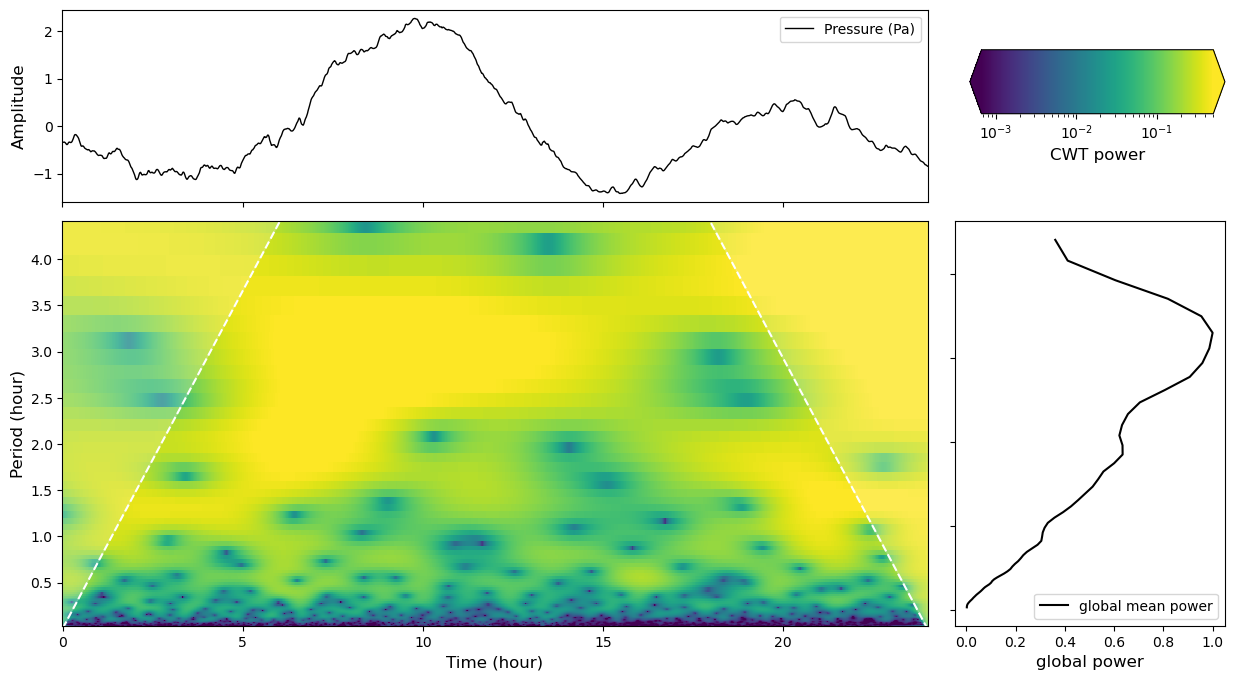

In [14]:
# ttt = ffbi.select(channel="*O")[0].times()
# arr = ffbi.select(channel="*O")[0].data

ttt = promy.select(channel="*DI")[0].times()
arr = promy.select(channel="*DI")[0].data
dt = 60


out = __compute_cwt(ttt, arr, dt, datalabel="Pressure (Pa)", tscale="hour", cmap_scale="log",
                    period=True, fmax=False, plot=True, normalize=True)

out['fig'].savefig(path_to_figs+f"comparison_{tbeg.date}_{tend.date}_cwt.png", dpi=200, format="png", bbox_inches='tight')
